In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e5/sample_submission.csv
/kaggle/input/playground-series-s3e5/train.csv
/kaggle/input/playground-series-s3e5/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import cohen_kappa_score

In [3]:
from sklearn import tree

In [4]:
train=pd.read_csv('/kaggle/input/playground-series-s3e5/train.csv')
sub=pd.read_csv('/kaggle/input/playground-series-s3e5/sample_submission.csv')
test=pd.read_csv('/kaggle/input/playground-series-s3e5/test.csv')

## Data normalization

In [5]:
y=train.pop('quality')
x=train.drop('Id',axis=1)

In [6]:
# # min max normalization
def min_max_normalization(df):
    return (df - df.min()) /(df.max()-df.min())
x=min_max_normalization(x)
x.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.275229,0.228571,0.513158,0.078125,0.151741,0.432836,0.113475,0.414831,0.567308,0.243590,0.641509
1,0.394495,0.085714,0.960526,0.085937,0.199005,0.432836,0.212766,0.621880,0.557692,0.179487,0.773585
2,0.192661,0.235714,0.039474,0.070312,0.116915,0.029851,0.017730,0.479442,0.750000,0.217949,0.490566
3,0.284404,0.492857,0.289474,0.109375,0.179104,0.149254,0.205674,0.530837,0.442308,0.089744,0.207547
4,0.321101,0.128571,0.394737,0.085937,0.166667,0.134328,0.134752,0.320852,0.442308,0.621795,0.150943


In [7]:
# # z_score normaliation
# def z_score_normalization(df):
#     return (df - df.mean()) /df.std()
# x=z_score_normalization(x)
# x.head()

# Model

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

unique, counts = np.unique(y, return_counts=True)
class_weights = dict(zip(unique, 1/counts))

# Define the parameter grid to search
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [1, 2, 3, 4, 5,10,15,20, None],
             'splitter':['best','random'],
              'max_leaf_nodes':[3,5,7,10,15,20,25,50,100],
             'class_weight':['class_weights',None]}

# Initialize the DecisionTreeClassifier
dtc = DecisionTreeClassifier()

# Use GridSearchCV to find the best hyperparameters for the classifier
grid_search = GridSearchCV(dtc, param_grid, cv=5)
grid_search.fit(x, y)

# Print the best hyperparameters found by GridSearchCV
print("Best hyperparameters: ", grid_search.best_params_)


Best hyperparameters:  {'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 25, 'splitter': 'best'}


In [9]:
train_x,val_x,train_y,val_y=train_test_split(x,y,train_size=0.75,random_state=1)
model=DecisionTreeClassifier(criterion='entropy',max_depth=5,splitter='best',max_leaf_nodes=25,random_state=1) # ,
clf=model.fit(train_x,train_y)
y_pred=clf.predict(train_x)
val_pred=clf.predict(val_x)
score_train=cohen_kappa_score(y_pred,train_y)
score_val=cohen_kappa_score(val_pred,val_y)
print(score_train,score_val)

0.41115828661982234 0.2963972575258731


# Tree Visualization

In [10]:
n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i
            )
        )
    else:
        print(
            "{space}node={node} is a split node: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
            )
        )

The binary tree structure has 49 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 10] <= 0.2358490601181984 else to node 2.
	node=1 is a split node: go to node 5 if X[:, 9] <= 0.16346154361963272 else to node 6.
	node=2 is a split node: go to node 3 if X[:, 9] <= 0.18910256773233414 else to node 4.
		node=3 is a split node: go to node 7 if X[:, 9] <= 0.1250000037252903 else to node 8.
		node=4 is a split node: go to node 9 if X[:, 10] <= 0.46226415038108826 else to node 10.
		node=5 is a split node: go to node 21 if X[:, 10] <= 0.17924528568983078 else to node 22.
		node=6 is a split node: go to node 13 if X[:, 9] <= 0.22756410390138626 else to node 14.
			node=7 is a split node: go to node 27 if X[:, 10] <= 0.7358490526676178 else to node 28.
			node=8 is a split node: go to node 17 if X[:, 7] <= 0.37812040746212006 else to node 18.
			node=9 is a split node: go to node 19 if X[:, 5] <= 0.5149253606796265 else to node 20.
			node=10 is a split 

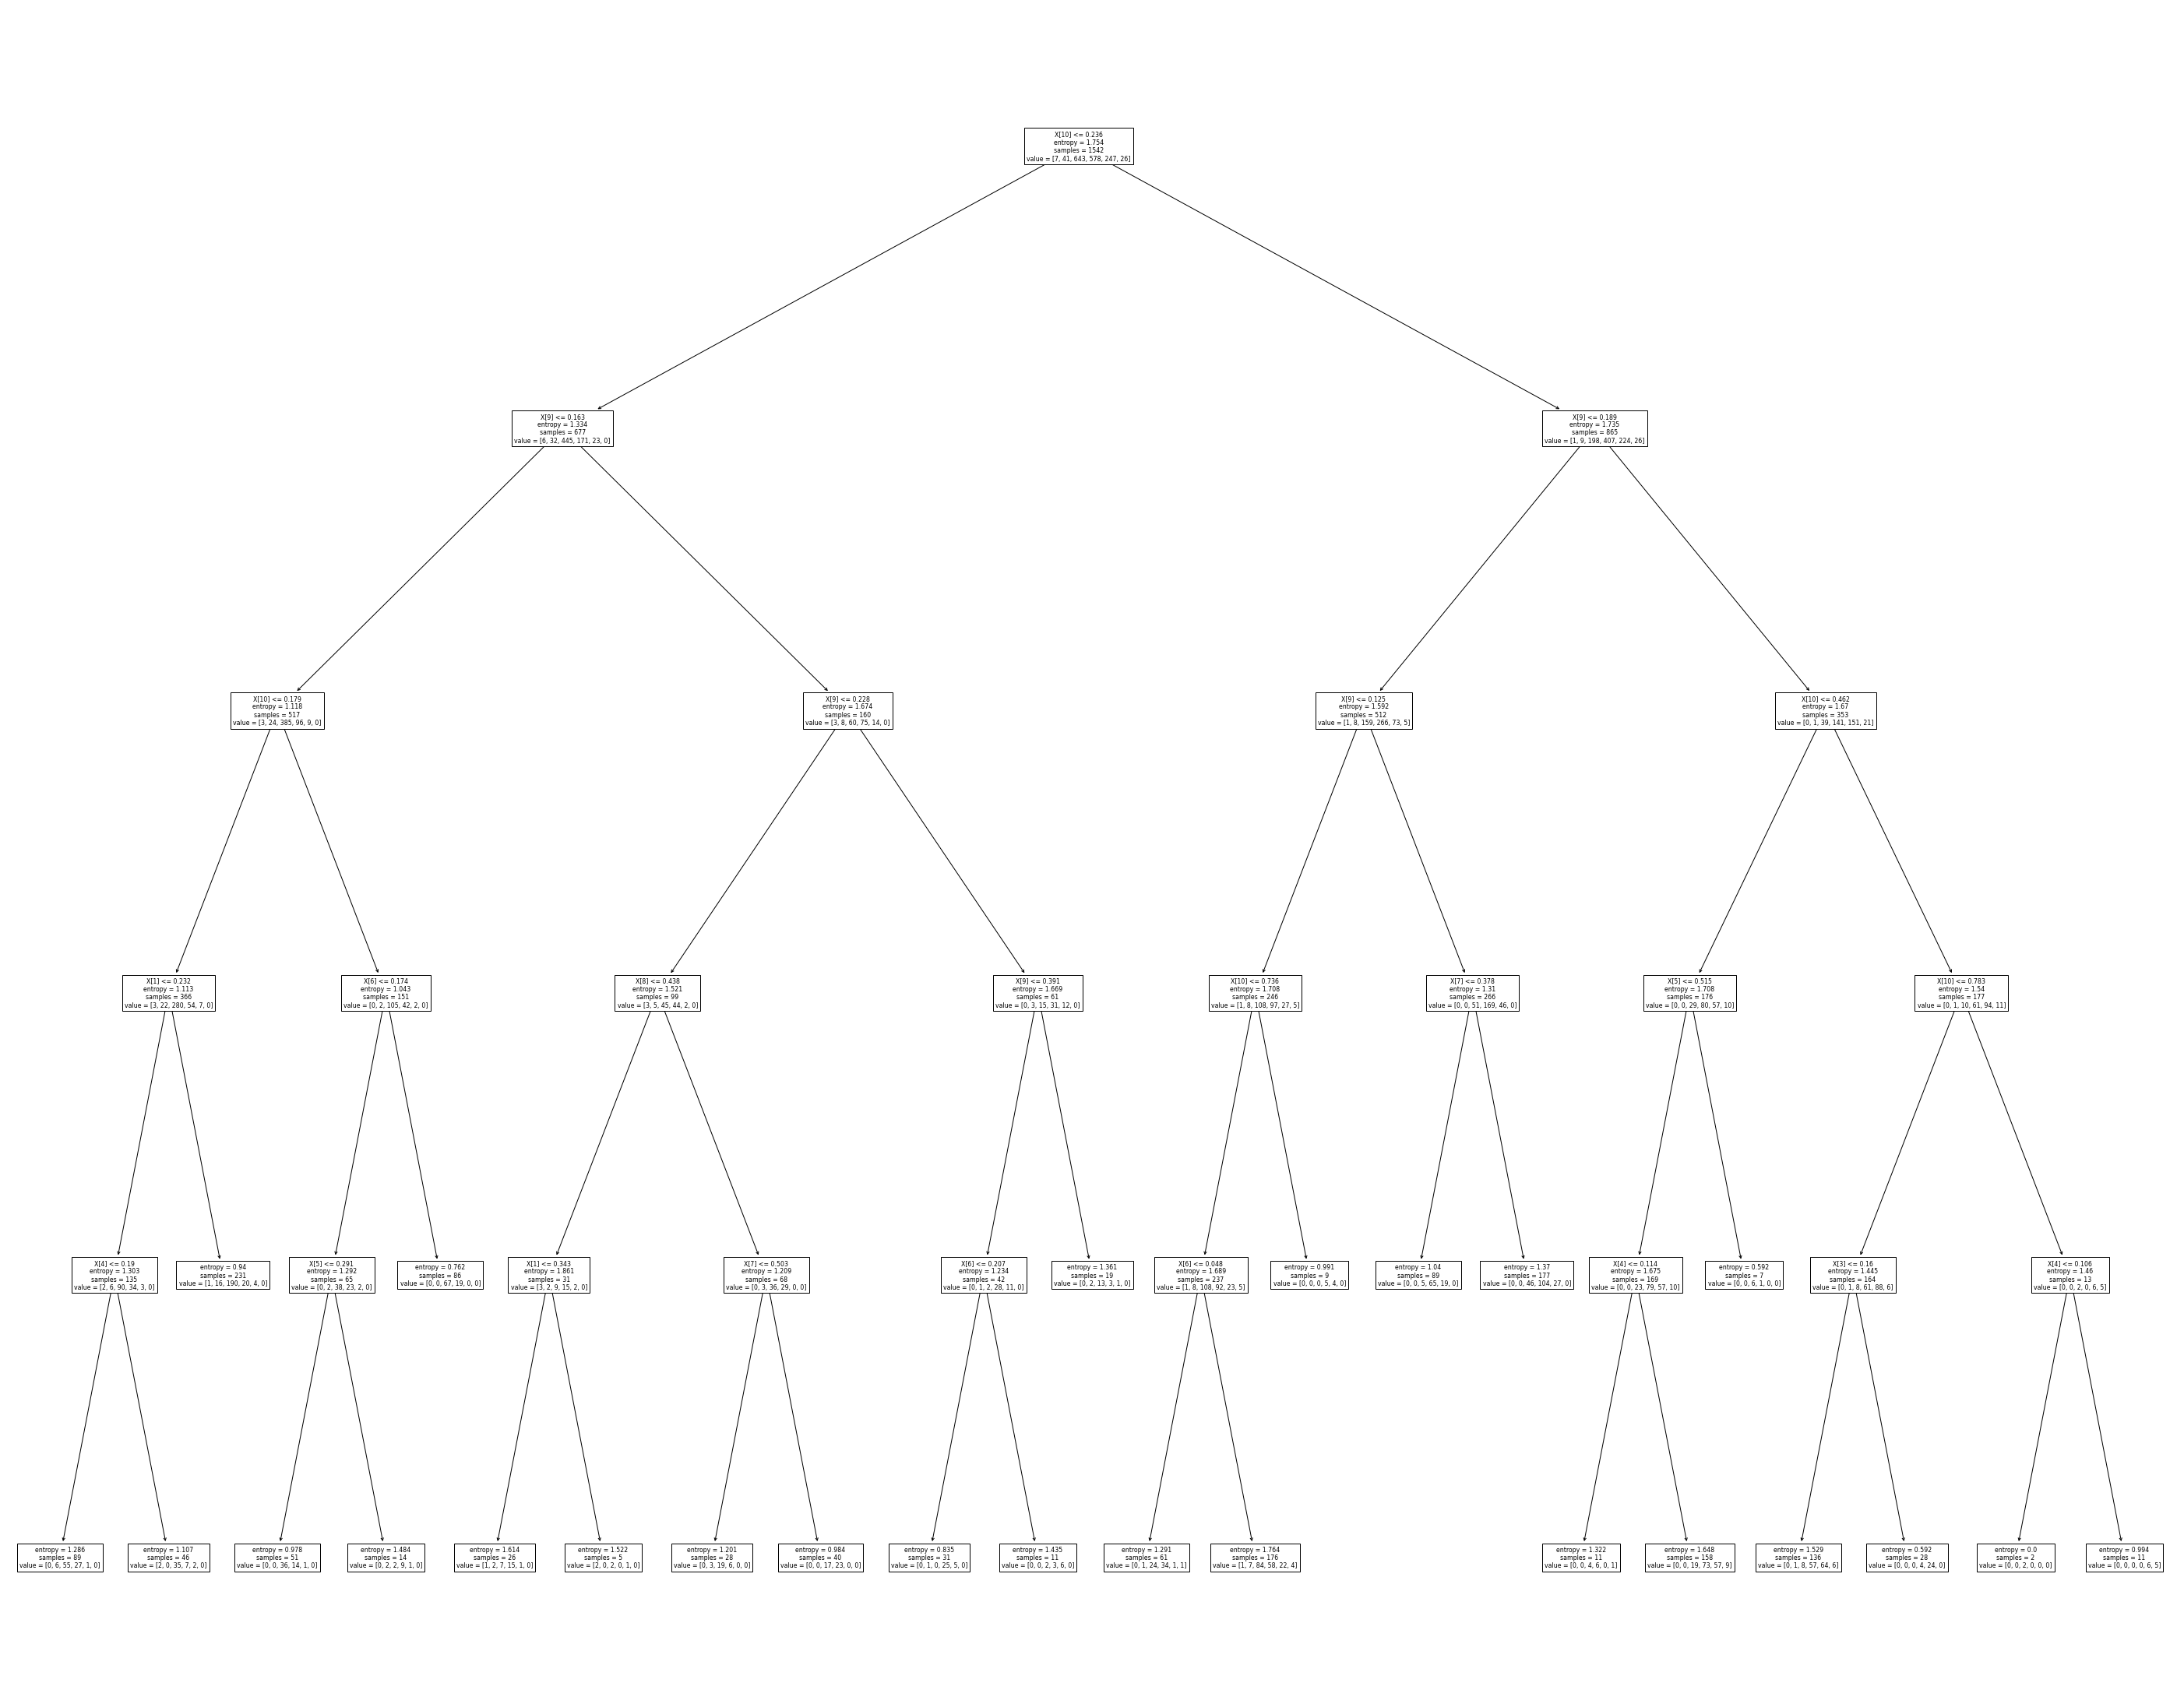

In [11]:
plt.figure(figsize=(50,40))
tree.plot_tree(clf)
plt.show()

In [12]:
test_x=test.iloc[:,1:]
#test_x=min_max_normalization(test_x)
test_x.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.2,0.510,0.01,2.0,0.077,31.0,54.0,0.99748,3.39,0.59,9.8
1,7.2,0.755,0.15,2.0,0.102,14.0,35.0,0.99586,3.33,0.68,10.0
2,8.4,0.460,0.40,2.0,0.065,21.0,50.0,0.99774,3.08,0.65,9.5
3,8.0,0.470,0.40,1.8,0.056,14.0,25.0,0.99480,3.30,0.65,11.7
4,6.5,0.340,0.32,2.1,0.044,8.0,94.0,0.99356,3.23,0.48,12.8


In [13]:
#model.fit(x,y)
y_pred=model.predict(test_x)
submission=pd.DataFrame({'Id':test['Id'],'quality':y_pred})
submission.to_csv('submission.csv',index=False)